In [1]:
import os
import chromadb
from chromadb.config import Settings
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
import pandas as pd
from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings


load_dotenv()

client = chromadb.HttpClient(
    host="localhost",
    port=6854,
    settings=Settings(
        chroma_client_auth_provider="chromadb.auth.basic_authn.BasicAuthClientProvider",
        chroma_client_auth_credentials=os.getenv("CHROMA_CLIENT_AUTH_CREDENTIALS"),
    )
)

print(client.heartbeat())
    
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


/home/halil/.pyenv/versions/DI502/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


1731507489458347591


In [2]:
cet = client.get_collection("MeETUVectorDB_Chunks")
result = cet.query(query_texts="How can I connect wifi?", n_results=4)

In [3]:
[doc for sublist in result["documents"] for doc in sublist]

['Q: How can I connect to meturoam network? A: How can I connect to meturoam network? A device must support WPA2 Enterprise with PEAP/MSCHAPv2 in order to be able to connect to METU wireless network, meturoam. Please click here for a list of some popular devices that are known to NOT work on the meturoam wireless network. To connect to the meturoam wireless network, you need a METU usercode and a password for meturoam. If you have a password, please continue to HOW-TO section. If you didn\'t create a password for meturoam or you want to renew your password, please visit https://netregister.metu.edu.tr and click Wireless icon, then click "meturoam" icon. In the meturoam menu, please provide a new password to be used only for this service with your user code. (In some Android and IOS devices, some special characters like #, \', $ in the password may cause problems to connect to meturoam. If you can connect to meturoam via a computer but having problems with Android or IOS devices, please

In [ ]:
# client.list_collections()
# client.delete_collection("MeETUVectorDB")
# client.delete_collection("MeETUVectorDB_Chunks")

In [3]:
def load_and_preprocess(file_path, file_name):
    df = pd.read_excel(file_path)
    
    if file_name == "FAQs_eng.xlsx":
        df["text_content"] = df["question"] + " " + df["answer"]
        df["metadata"] = df.apply(lambda row: {
            "type": "FAQ",
            "question": row.get("question", ""),
            "answer": row.get("answer", ""),
            "link": row.get("link", "")
        }, axis=1)
        
    elif file_name == "How_will_you_register.xlsx":
        df["text_content"] = df["question"] + " " + df["answer"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Registration",
            "question": row.get("question", ""),
            "answer": row.get("answer", ""),
            "link": row.get("link", "")
        }, axis=1)
    
    elif file_name == "REGISTRATION_PROCEDURES.xlsx":
        df["text_content"] = df["Question"] + " " + df["Answer"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Registration",
            "question": row.get("Question", ""),
            "answer": row.get("Answer", "")
        }, axis=1)
        
    elif file_name in ["courses_eng.xlsx", "courses_eng_undergrad.xlsx"]:
        df["text_content"] = df["course"] + " " + df["course_content"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Course",
            "course_title": row.get("course", ""),
            "department": row.get("Department", ""),
            "course_objective": row.get("course_objective", ""),
            "course_content": row.get("course_content", ""),
            "link": row.get("link", ""),
            "level": "undergrad" if "undergrad" in file_name else "general"
        }, axis=1)
        
    elif file_name == "accomadation_eng.xlsx":
        df.columns = ["facility", "location"]
        df["text_content"] = df["facility"] + " " + df["location"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Accommodation",
            "facility": row.get("facility", ""),
            "location": row.get("location", "")
        }, axis=1)
        
    elif file_name == "extras.xlsx":
        df.columns = ["category", "details"]
        df["text_content"] = df["category"] + " " + df["details"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Extras",
            "category": row.get("category", ""),
            "details": row.get("details", "")
        }, axis=1)
        
    elif file_name == "sport_clubs.xlsx":
        df["text_content"] = df["club_name"] + " " + df["description"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Club",
            "club_name": row.get("club_name", ""),
            "category": "sport",
            "description": row.get("description", "")
        }, axis=1)
        
    elif file_name == "student_clubs_eng.xlsx":
        df["text_content"] = df["Student Club"] + " " + df["information"]
        df["metadata"] = df.apply(lambda row: {
            "type": "Club",
            "club_name": row.get("Student Club", ""),
            "category": "student",
            "description": row.get("information", "")
        }, axis=1)
        
    df["text_content"] = df["text_content"].str.replace(r"\s+", " ", regex=True).str.strip()
    df.dropna(subset=["text_content"], inplace=True)
    
    return df[["text_content", "metadata"]].to_dict(orient="records")


data_dir = "/home/halil/Desktop/MeETU/Data"
file_paths = {
    "FAQs_eng.xlsx": f"{data_dir}/FAQs_eng.xlsx",
    "How_will_you_register.xlsx": f"{data_dir}/How_will_you_register.xlsx",
    "REGISTRATION_PROCEDURES.xlsx": f"{data_dir}/REGISTRATION_PROCEDURES.xlsx",
    "accomadation_eng.xlsx": f"{data_dir}/accomadation_eng.xlsx",
    "courses_eng.xlsx": f"{data_dir}/courses_eng.xlsx",
    "courses_eng_undergrad.xlsx": f"{data_dir}/courses_eng_undergrad.xlsx",
    "extras.xlsx": f"{data_dir}/extras.xlsx",
    "sport_clubs.xlsx": f"{data_dir}/sport_clubs.xlsx",
    "student_clubs_eng.xlsx": f"{data_dir}/student_clubs_eng.xlsx"
}

all_docs = []
for file_name, path in file_paths.items():
    docs = load_and_preprocess(path, file_name)
    all_docs.extend(docs)

In [4]:
import json
with open("all_docs.json", "w", encoding="utf-8") as f:
    json.dump(all_docs, f, ensure_ascii=False, indent=4)

In [7]:
collection_name = "MeETUVectorDB"
if collection_name not in client.list_collections():
    client.create_collection(collection_name)
collection = client.get_collection(collection_name)

for i, doc in enumerate(all_docs):
    text = doc["text_content"]
    metadata = doc["metadata"]
    
    embedding = embedding_model.embed_query(text)
    doc_id = f"doc_{i}"  # Generate a unique ID for each document
    
    collection.add(
        documents=[text],
        metadatas=[metadata],
        embeddings=[embedding],
        ids=[doc_id]
    )


In [8]:
collection.count()

7757

In [9]:
for i in range(10):
    print(collection.get(ids=f"doc_{i}")["documents"][0])

How can I connect to eduroam wireless network using my Windows 10 computer? If you are using Windows 10, then you do not need to install a program. In the list of wireless networks, please select eduroam and use your usercode and password to connect. Do not forget to add @metu.edu.tr to the usercode (like username@metu.edu.tr)
How can I connect to meturoam network? A device must support WPA2 Enterprise with PEAP/MSCHAPv2 in order to be able to connect to METU wireless network, meturoam. Please click here for a list of some popular devices that are known to NOT work on the meturoam wireless network. To connect to the meturoam wireless network, you need a METU usercode and a password for meturoam. If you have a password, please continue to HOW-TO section. If you didn't create a password for meturoam or you want to renew your password, please visit https://netregister.metu.edu.tr and click Wireless icon, then click "meturoam" icon. In the meturoam menu, please provide a new password to be

Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors


Maximum token size: 3649


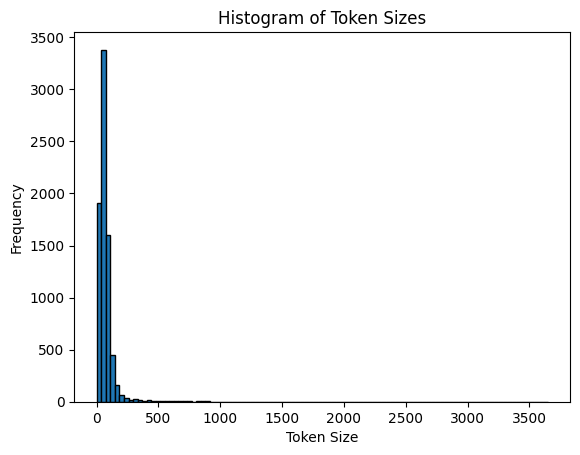

In [10]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

token_sizes = []

for i in range(collection.count()):
    doc_text = collection.get(ids=[f"doc_{i}"])["documents"][0]
    
    tokens = tokenizer(doc_text, truncation=False, add_special_tokens=False)["input_ids"]
    token_size = len(tokens)
    token_sizes.append(token_size)

max_token_size = max(token_sizes)
print("Maximum token size:", max_token_size)

plt.hist(token_sizes, bins=100, edgecolor="black")
plt.xlabel("Token Size")
plt.ylabel("Frequency")
plt.title("Histogram of Token Sizes")
plt.show()


In [11]:
from transformers import AutoTokenizer
import json
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

with open("all_docs.json", "r", encoding="utf-8") as f:
    all_docs = json.load(f)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

chunk_size = 250  # Target chunk size
min_chunk_size = 150  # Minimum tokens in a chunk

chunked_collection_name = "MeETUVectorDB_Chunks"
if chunked_collection_name not in client.list_collections():
    client.create_collection(chunked_collection_name)
chunked_collection = client.get_collection(chunked_collection_name)

def count_tokens(text):
    return len(tokenizer.encode(text, add_special_tokens=False))

for i, doc in enumerate(all_docs):
    doc_id = f"doc_{i}"

    _question = doc["metadata"].get("question", "No question provided")
    _text_content = doc.get("text_content", "No content provided")
    sentences = sent_tokenize(_text_content)

    chunks = []
    current_chunk = []
    current_chunk_tokens = 0

    for sentence in sentences:
        sentence_tokens = count_tokens(sentence)

        if current_chunk_tokens + sentence_tokens > chunk_size and current_chunk_tokens >= min_chunk_size:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_chunk_tokens = 0

        current_chunk.append(sentence)
        current_chunk_tokens += sentence_tokens

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    for chunk_num, chunk_text in enumerate(chunks, start=1):
        chunk_id = f"{doc_id}_{chunk_num}"
        
        chunk_with_question = f"Q: {_question} A: {chunk_text}"
        
        metadata = {**doc["metadata"], "original_doc_id": doc_id}
        
        chunked_collection.add(
            documents=[chunk_with_question],
            metadatas=[metadata],
            embeddings=[embedding_model.embed_query(chunk_with_question)],
            ids=[chunk_id]
        )


[nltk_data] Downloading package punkt to /home/halil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Maximum token size: 448


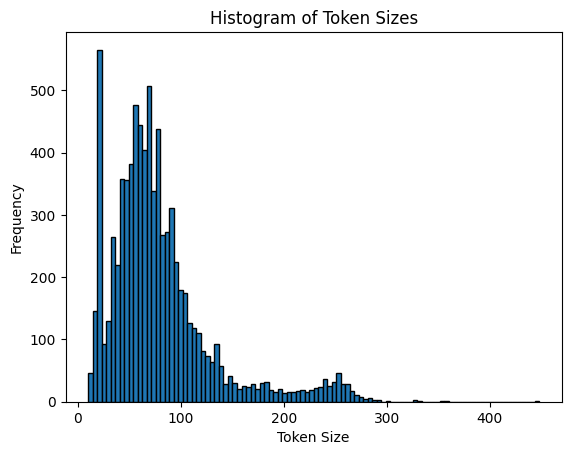

In [12]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
all_doc_ids = chunked_collection.get(ids=None)["ids"]  # Retrieve all IDs
token_sizes = []

for doc_id in all_doc_ids:
    doc_text = chunked_collection.get(ids=[doc_id])["documents"][0]
    
    tokens = tokenizer(doc_text, truncation=False, add_special_tokens=False)["input_ids"]
    token_size = len(tokens)
    token_sizes.append(token_size)

max_token_size = max(token_sizes)
print("Maximum token size:", max_token_size)

plt.hist(token_sizes, bins=100, edgecolor="black")
plt.xlabel("Token Size")
plt.ylabel("Frequency")
plt.title("Histogram of Token Sizes")
plt.show()
